<a href="https://colab.research.google.com/github/Proveyron/APS-T962/blob/main/APS_OTIMIZA%C3%87%C3%82O_DE_SISTEMAS_T962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text(value='AAPL,MSFT,GOOGL', description='Ativos:')

Text(value='01/01/2020', description='Data de Início (dd/mm/aaaa):')

Text(value='01/01/2023', description='Data de Fim (dd/mm/aaaa):')

FloatSlider(value=0.2, description='Risco Máximo:', max=0.5, min=0.05, step=0.01)

Button(description='Processar', style=ButtonStyle())

[*********************100%***********************]  3 of 3 completed


Pesos ótimos: [0.56072093 0.06478782 0.37449124]


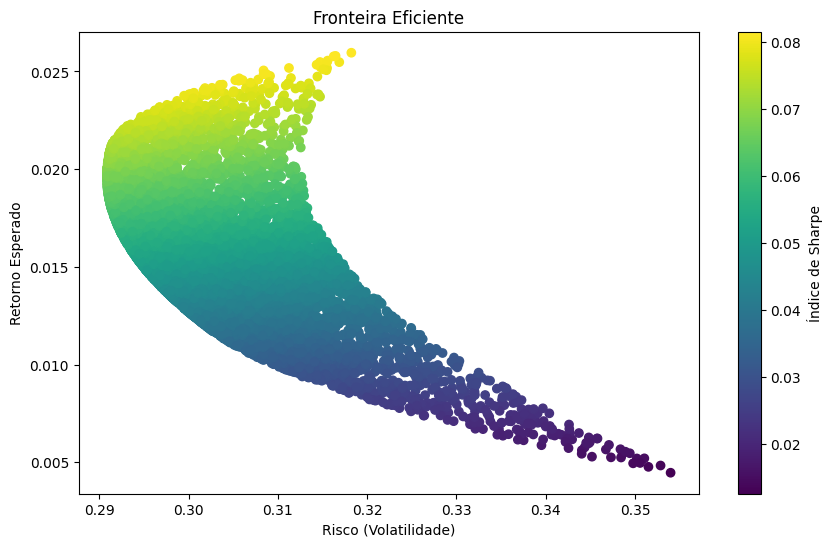

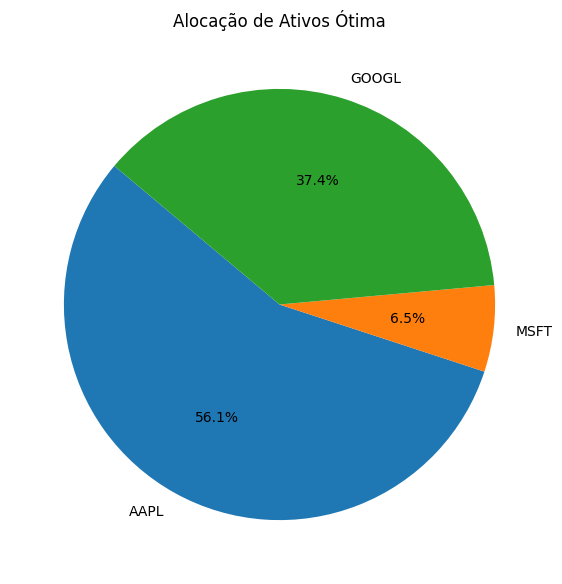

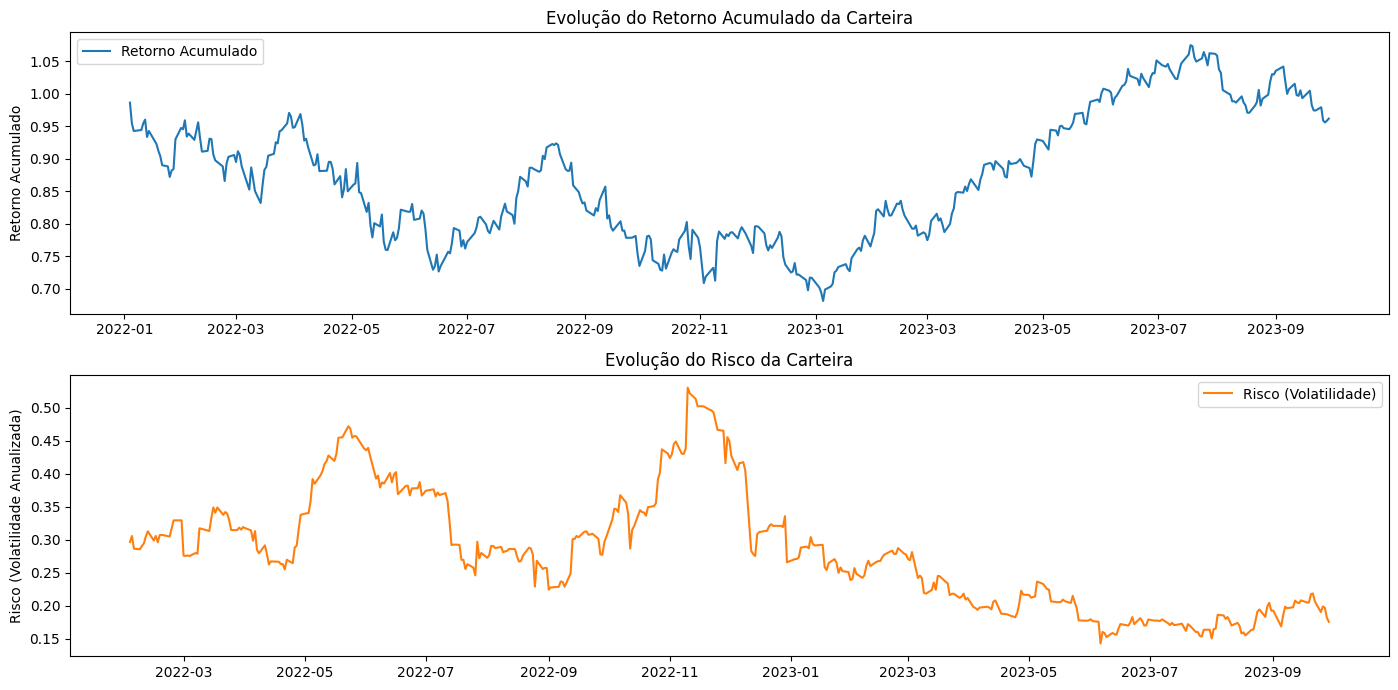

In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

# Funções de apoio

# Calcular o retorno esperado da carteira
def retorno_carteira(pesos, retornos):
    return np.dot(pesos, retornos)

# Calcular o risco da carteira (volatilidade)
def risco_carteira(pesos, matriz_cov):
    return np.sqrt(np.dot(pesos.T, np.dot(matriz_cov, pesos)))

# Função objetivo para maximizar o retorno (mínimo do negativo do retorno)
def objetivo(pesos, retornos):
    return -retorno_carteira(pesos, retornos)

# Restrição de risco (limite de volatilidade)
def restricao_risco(pesos, matriz_cov, risco_maximo):
    return risco_maximo - risco_carteira(pesos, matriz_cov)

# Restrição para que a soma dos pesos seja igual a 1
def restricao_pesos(pesos):
    return np.sum(pesos) - 1

# Definir dicionário de cores para os ativos
def definir_cores_ativos(ativos):
    cores = plt.get_cmap('tab10')  # Usando o colormap 'tab10', que tem 10 cores distintas
    return {ativo: cores(i % 10) for i, ativo in enumerate(ativos)}

# Função para plotar a fronteira eficiente
def plotar_fronteira_eficiente(retornos, matriz_cov):
    num_carteiras = 10000
    resultados = np.zeros((3, num_carteiras))

    for i in range(num_carteiras):
        pesos = np.random.random(len(retornos))
        pesos /= np.sum(pesos)
        retorno_carteira_valor = retorno_carteira(pesos, retornos)
        risco_carteira_valor = risco_carteira(pesos, matriz_cov)
        resultados[0, i] = retorno_carteira_valor
        resultados[1, i] = risco_carteira_valor
        resultados[2, i] = retorno_carteira_valor / risco_carteira_valor  # Índice de Sharpe

    plt.figure(figsize=(10, 6))
    plt.scatter(resultados[1, :], resultados[0, :], c=resultados[2, :], cmap='viridis')
    plt.colorbar(label='Índice de Sharpe')
    plt.xlabel('Risco (Volatilidade)')
    plt.ylabel('Retorno Esperado')
    plt.title('Fronteira Eficiente')
    plt.show()

# Gráfico de alocação de ativos com cores
def plotar_alocacao(pesos, ativos, cores):
    plt.figure(figsize=(7, 7))
    plt.pie(pesos, labels=ativos, autopct='%1.1f%%', startangle=140, colors=[cores[ativo] for ativo in ativos])
    plt.title('Alocação de Ativos Ótima')
    plt.show()

# Função para exibir gráfico de evolução de retorno e risco
def plotar_evolucao_retorno_risco(dados, pesos, cores, ativos):
    retornos_diarios = dados.pct_change()  # Retornos diários
    retorno_carteira_diario = pd.Series(np.dot(retornos_diarios, pesos), index=retornos_diarios.index)
    retorno_acumulado = (1 + retorno_carteira_diario).cumprod()  # Retorno acumulado

    # Risco (volatilidade) móvel
    volatilidade_movel = retorno_carteira_diario.rolling(window=21).std() * np.sqrt(252)  # Risco anualizado com janela de 21 dias (aprox. 1 mês)

    plt.figure(figsize=(14, 7))

    # Plotando o retorno acumulado da carteira
    plt.subplot(2, 1, 1)
    plt.plot(retorno_acumulado, label="Retorno Acumulado", color=cores[ativos[0]])
    plt.title('Evolução do Retorno Acumulado da Carteira')
    plt.ylabel('Retorno Acumulado')
    plt.legend()

    # Plotando a volatilidade (risco) móvel da carteira
    plt.subplot(2, 1, 2)
    plt.plot(volatilidade_movel, label="Risco (Volatilidade)", color=cores[ativos[1]])
    plt.title('Evolução do Risco da Carteira')
    plt.ylabel('Risco (Volatilidade Anualizada)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Função principal para realizar a otimização e visualização
def otimizar_carteira(ativos, data_inicio, data_fim, risco_maximo):
    # Converter as datas do formato dd/mm/aaaa para yyyy-mm-dd
    data_inicio = datetime.strptime(data_inicio, "%d/%m/%Y").strftime("%Y-%m-%d")
    data_fim = datetime.strptime(data_fim, "%d/%m/%Y").strftime("%Y-%m-%d")

    # Coletar dados históricos de preços
    dados = yf.download(ativos, start=data_inicio, end=data_fim)['Adj Close']

    # Calcular retornos diários e volatilidade anualizada
    retornos = dados.pct_change().mean() * 252  # Retorno anualizado
    matriz_cov = dados.pct_change().cov() * 252  # Matriz de covariância anualizada

    # Definir variáveis do problema
    n_ativos = len(ativos)
    array_retornos = np.array(retornos)
    pesos_iniciais = np.ones(n_ativos) / n_ativos
    limites = [(0, 1) for _ in range(n_ativos)]

    # Adicionando múltiplas restrições: soma dos pesos igual a 1 e restrição de risco
    restricoes = [
        {'type': 'eq', 'fun': restricao_pesos},  # A soma dos pesos deve ser igual a 1
        {'type': 'ineq', 'fun': restricao_risco, 'args': (matriz_cov, risco_maximo)}  # Risco máximo
    ]

    # Otimização usando 'SLSQP'
    resultado = minimize(objetivo, pesos_iniciais, args=(array_retornos,), method='SLSQP',
                         bounds=limites, constraints=restricoes)

    # Pesos otimizados
    pesos_otimos = resultado.x
    print("Pesos ótimos:", pesos_otimos)

    # Definir cores para os ativos
    cores = definir_cores_ativos(ativos)

    # Visualizações
    plotar_fronteira_eficiente(array_retornos, matriz_cov)
    plotar_alocacao(pesos_otimos, ativos, cores)
    plotar_evolucao_retorno_risco(dados, pesos_otimos, cores, ativos)

# Função para processar a entrada do usuário
def processar_entrada(ativos, data_inicio, data_fim, risco_maximo):
    lista_ativos = ativos.split(',')
    otimizar_carteira(lista_ativos, data_inicio, data_fim, risco_maximo)

# Criar widgets para os parâmetros do usuário
ativos_widget = widgets.Text(value='AAPL,MSFT,GOOGL', description='Ativos:')
data_inicio_widget = widgets.Text(value='01/01/2020', description='Data de Início (dd/mm/aaaa):')
data_fim_widget = widgets.Text(value='01/01/2023', description='Data de Fim (dd/mm/aaaa):')
risco_maximo_widget = widgets.FloatSlider(value=0.2, min=0.05, max=0.5, step=0.01, description='Risco Máximo:')

# Botão para processar a entrada
botao = widgets.Button(description="Processar")

# Função para ser chamada ao clicar no botão
def ao_clicar_botao(b):
    processar_entrada(ativos_widget.value, data_inicio_widget.value, data_fim_widget.value, risco_maximo_widget.value)

botao.on_click(ao_clicar_botao)

# Mostrar widgets
display(ativos_widget, data_inicio_widget, data_fim_widget, risco_maximo_widget, botao)
